In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

df = pd.read_json('data.json')

In [2]:
list = []
date_range = pd.date_range(start='2020-01-01', end='2022-12-31')

for index, row in df.iterrows():
    if row['name'] == '2020':
        i = 0
        for suhu in row['data']:
            list.append({
                'date': date_range[i],
                'temperature': suhu
            })
            i += 1
    elif row['name'] == '2021':
        i = 365*1
        for suhu in row['data']:
            list.append({
                'date': date_range[i],
                'temperature': suhu
            })
            i += 1
    elif row['name'] == '2022':
        i = 365*2
        for suhu in row['data']:
            list.append({
                'date': date_range[i],
                'temperature': suhu
            })
            i += 1

df_suhu = pd.DataFrame(list)

df_suhu_filter = pd.DataFrame(df_suhu.dropna())

df_suhu = df_suhu_filter
df_suhu

,date,temperature
0,2020-01-01,13.098
1,2020-01-02,13.192
2,2020-01-03,13.177
3,2020-01-04,13.152
4,2020-01-05,13.061
...,...,...
1092,2022-12-26,12.903
1093,2022-12-27,12.858
1094,2022-12-28,12.839
1095,2022-12-29,12.869


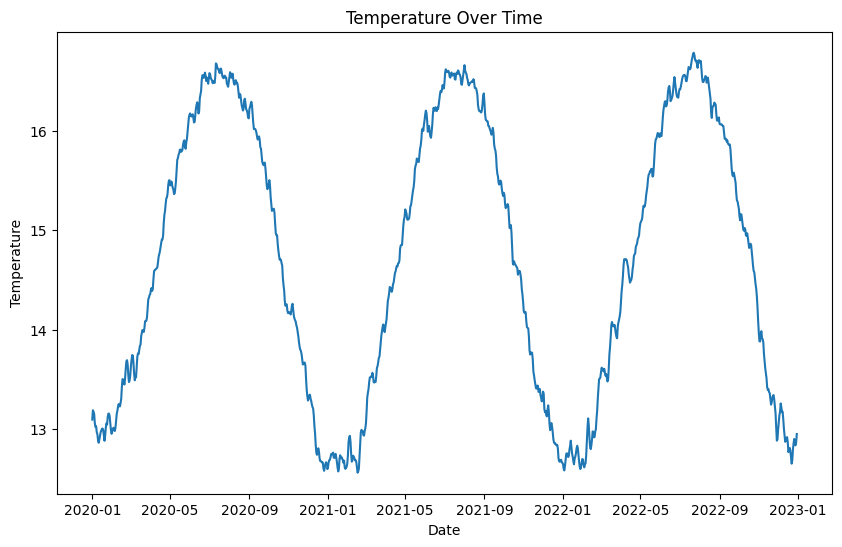

In [3]:
# Data suhu per hari pada tahun 2020
plt.figure(figsize=(10, 6))
plt.plot(df_suhu['date'], df_suhu['temperature'])
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [4]:
df_suhu['day_of_year'] = df_suhu['date'].dt.day_of_year
df_suhu['lag_1'] = df_suhu['temperature'].shift(1)
df_suhu['lag_2'] = df_suhu['temperature'].shift(2)

df_suhu = df_suhu.dropna()

x = df_suhu[['day_of_year', 'lag_1', 'lag_2']].values
y = df_suhu['temperature'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print(df_suhu['day_of_year'])
print(X_train.shape, X_test.shape)
print(X_train[1][0])

2         3
3         4
4         5
5         6
6         7
       ... 
1092    360
1093    361
1094    362
1095    363
1096    364
Name: day_of_year, Length: 1094, dtype: int32
(875, 3) (219, 3)
4.0


In [5]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled[:5])

[[0.00547945 0.15264949 0.12980068]
 [0.00821918 0.1490034  0.15264949]
 [0.0109589  0.14292659 0.1490034 ]
 [0.01369863 0.120807   0.14292659]
 [0.01643836 0.11157025 0.120807  ]]


In [6]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=L2(0.01)))
model.add(Dropout(0.2))  # Dropout to reduce overfitting by randomly dropping nodes.
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model.summary()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 210.1921 - val_loss: 216.5746
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 194.1861 - val_loss: 178.8474
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 154.3361 - val_loss: 83.1964
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 67.6708 - val_loss: 16.1130
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.4424 - val_loss: 3.6210
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5536 - val_loss: 2.3402
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2489 - val_loss: 2.2697
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2177 - val_loss: 2.2768
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4118 - val_loss: 2.2781
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3909 - val_loss: 2.2696
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.2276 - val_loss: 2.2662
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 

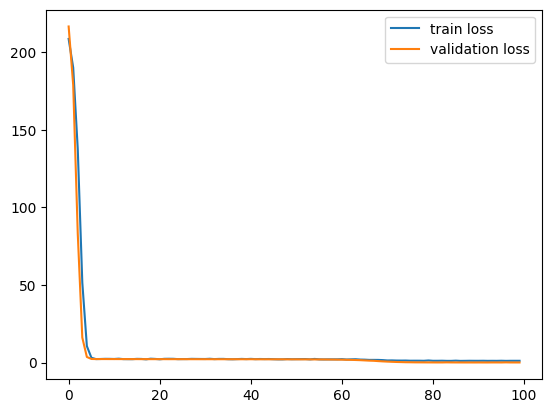

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stop],
    )

# This will stop the training if there's no improvement in 'validation loss'

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [8]:
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0781 
Test Loss: 0.07650438696146011


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


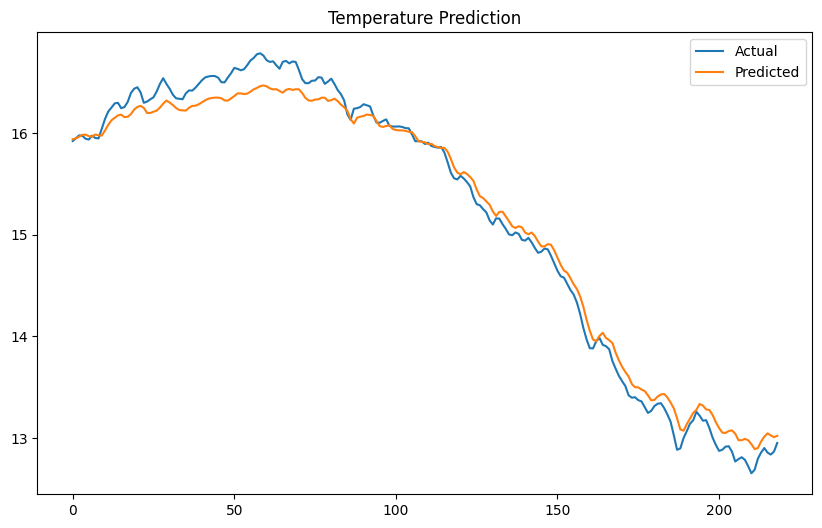

In [9]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Plot the predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Temperature Prediction')
plt.show()

In [10]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
accuracy = 100 - mape

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"Model Accuracy: {accuracy:.2f}%")

Mean Absolute Error (MAE): 0.13190859253765783
Mean Squared Error (MSE): 0.023811488902589488
Root Mean Squared Error (RMSE): 0.15430971746001446
R² Score: 0.9873197774717015
Model Accuracy: 99.13%


In [11]:
list = []
date_range = pd.date_range(start='2023-01-01', end='2023-12-31')

for index, row in df.iterrows():
    if row['name'] == '2023':
        i = 0
        for suhu in row['data']:
            if i < 365:
                list.append({
                'date': date_range[i],
                'temperature': suhu
                })
                i += 1

df_future = pd.DataFrame(list)

df_future = pd.DataFrame(df_future.dropna())

df_future

,date,temperature
0,2023-01-01,12.965
1,2023-01-02,12.951
2,2023-01-03,12.906
3,2023-01-04,12.829
4,2023-01-05,12.772
...,...,...
360,2023-12-27,13.509
361,2023-12-28,13.530
362,2023-12-29,13.506
363,2023-12-30,13.457
